In [1]:
import os
#This module provides a portable way of using operating system dependent functionality.
import sys
#This module provides access to some variables used or maintained by the interpreter and
#to functions that interact strongly with the interpreter
sys.path.append('..')

import lzma
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')

import pyquery
from ipywidgets import FloatProgress
from IPython.display import display

from config import settings
import utils
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
cases_format="json"
#else "xml"
#cases_format="xml"
compressed_file = utils.get_cases_from_bulk(jurisdiction="New Mexico", data_format=cases_format)

downloading New Mexico-20200302-text.zip into ../data dir


66568it [00:49, 1332.46it/s]


extracting New Mexico-20200302-text.zip into ../data dir
Done.


In [3]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open(compressed_file) as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Selected jurisdiction: New Mexico")
print("Number of Cases: ", len(cases))

Selected jurisdiction: New Mexico
Number of Cases:  18338


In [4]:
def parse_json(case):
    feat_dict = {}
    feat_dict["case_id"] = case['id']
    feat_dict["case_url"] = case['url']
    feat_dict["case_name"] = case['name']
    feat_dict["case_name_abbreviation"] = case['name_abbreviation']
    feat_dict["date"] = case['decision_date']
    feat_dict["citations"] = [citation for citation in case['citations'] if citation['type'] == 'official'][0]
    #feat_dict["volume"] = case['volume']
    feat_dict["court"] = case['court']['name']
    feat_dict["jurisdiction"] = case['jurisdiction']#['name_long']
    #feat_dict["name"] = case['jurisdiction']['name']
    feat_dict["judges"]=case["casebody"]["data"]["judges"]
    feat_dict["attorneys"]=case["casebody"]["data"]["attorneys"]
    feat_dict["author"]=case["casebody"]["data"]["opinions"][0]["author"]

    #Main text: opinions
    feat_dict["opinion"]=case["casebody"]["data"]["opinions"][0]["text"]

    return feat_dict

In [5]:
#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = parse_json(case) #json
    #doc = ET_parse_xml(case) #xml
    parsed_files.append(doc)
    bar.value += 1

FloatProgress(value=0.0, max=18338.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Author

In [6]:
raw_df = pd.DataFrame(parsed_files)
raw_df.head()

In [7]:
#Let's look at how many cases fall in each court
raw_df['court'].value_counts(normalize=False)

In [8]:
#Let's look at how many opinions each author has given
pd.set_option("display.max_rows", None)
print("There are ", len(raw_df['author'].value_counts(normalize=False)), "different 'author' fields. ")
raw_df['author'].value_counts(normalize=False)

# More on authors

In [9]:
most_prolific_authors = raw_df["author"].value_counts()
print(most_prolific_authors.head(5))

In [10]:
authors = {}
for _, opinion in raw_df.iterrows():
    if opinion["author"] and "curiam" not in opinion["author"]:
        author = opinion["author"]
        #author = [a.strip() for a in author.split(',')][0]
        #author = [a.strip() for a in author.split('.')][0]
        #author = [a.strip() for a in author.split(';')][0]
        #author = author.upper()
        year = pd.to_datetime(opinion["date"]).year
        if "curiam" in author.lower():
            author = 'Per Curiam.'
        #add to dictionary of authors with subdictionary of years for each author
        if author in authors:
            if year in authors[author]:
                authors[author][year] += 1
            else:
                authors[author][year] = 1
        else:
            authors[author] = {}
            authors[author][year] = 1

for author in authors:
    print(f"\033[1mAuthor: {author}\033[0m ")
    num_cases=0
    for year in authors[author]:
        print(f"{authors[author][year]} opinions in {year}")
        num_cases=num_cases+authors[author][year]
    print(f"In total: \033[1m{num_cases}\033[0m opinions.")
    print()

Author: MINZNER, Justice. 
15 opinions in 1997
9 opinions in 1998
10 opinions in 1996
10 opinions in 2004
7 opinions in 2005
8 opinions in 2002
3 opinions in 2001
13 opinions in 1995
9 opinions in 2003
5 opinions in 2007
7 opinions in 2006
In total: 96 opinions.

Author: WECHSLER, Judge. 
15 opinions in 1998
13 opinions in 1997
12 opinions in 1999
15 opinions in 2000
4 opinions in 1996
15 opinions in 2001
15 opinions in 2002
7 opinions in 2005
11 opinions in 1995
19 opinions in 2007
21 opinions in 2006
18 opinions in 2008
20 opinions in 2013
15 opinions in 2015
14 opinions in 2012
14 opinions in 2009
9 opinions in 2014
11 opinions in 2016
13 opinions in 2010
14 opinions in 2011
In total: 275 opinions.

Author: PICKARD, Judge. 
15 opinions in 1997
16 opinions in 1998
23 opinions in 1996
2 opinions in 1999
12 opinions in 2004
18 opinions in 2005
26 opinions in 2001
18 opinions in 2002
28 opinions in 1995
25 opinions in 1994
20 opinions in 1992
3 opinions in 1991
18 opinions in 1993
20 op

In total: 1 opinions.

Author: RAYNOLDS. J. 
1 opinions in 1921
In total: 1 opinions.

Author: BRATTON, District Judge. 
1 opinions in 1921
1 opinions in 1922
In total: 2 opinions.

Author: EDWIN MECHEM, District Judge 
1 opinions in 1921
In total: 1 opinions.

Author: APOD ACA,. Judge. 
1 opinions in 1988
In total: 1 opinions.

Author: RANSOM, Justice. GARCIA, Judge. 
1 opinions in 1988
In total: 1 opinions.

Author: PAYNE, Justice. FELTER, Justice, 
1 opinions in 1980
In total: 1 opinions.

Author: NIEVES, District Judge. 
1 opinions in 1981
In total: 1 opinions.

Author: WALTERS, Judge. LOPEZ, Judge 
1 opinions in 1980
In total: 1 opinions.

Author: GARCIA, District Judge. 
1 opinions in 1980
In total: 1 opinions.

Author: SANDENAW, District Judge. 
1 opinions in 1977
In total: 1 opinions.

Author: SANDRA A. GRISHAM, District Judge, by Order of Designation. 
1 opinions in 1986
In total: 1 opinions.

Author: GARNETT R. BURKS, Jr., District Judge 
1 opinions in 1987
In total: 1 opinio


Author: MAES, Chief Justice 
2 opinions in 2013
1 opinions in 2012
In total: 3 opinions.

Author: YANZI, Judge. 
1 opinions in 2012
1 opinions in 2016
In total: 2 opinions.

Author: MAES, Senior Justice. 
1 opinions in 2015
In total: 1 opinions.

Author: OPINION CASTILLO, Chief Judge. 
1 opinions in 2011
In total: 1 opinions.

Author: OPINION VIGIL, Judge. 
1 opinions in 2011
In total: 1 opinions.

Author: CHÁYEZ, Justice. 
1 opinions in 2016
In total: 1 opinions.

Author: HANISEE, J. 
1 opinions in 2013
In total: 1 opinions.

Author: CHÁVEZ, justice. 
1 opinions in 2013
In total: 1 opinions.

Author: MABRY, Justice. • 
1 opinions in 1939
In total: 1 opinions.

Author: REBECCA SITTERLY, District Judge. 
1 opinions in 1988
In total: 1 opinions.

Author: CHAVEZ, Justice.' 
1 opinions in 1961
In total: 1 opinions.

Author: COMPTON, Chief Justice 
1 opinions in 1961
In total: 1 opinions.

Author: TTTT...T T ,. LUJAN, Justice. 
1 opinions in 1953
In total: 1 opinions.

Author: Bell, Associ

In [11]:
for justice in most_prolific_authors.index.tolist()[:5]:
    print(justice)

SUTIN, Judge.
WOOD, Chief Judge.
HENDLEY, Judge.
COMPTON, Justice.
WOOD, Judge.


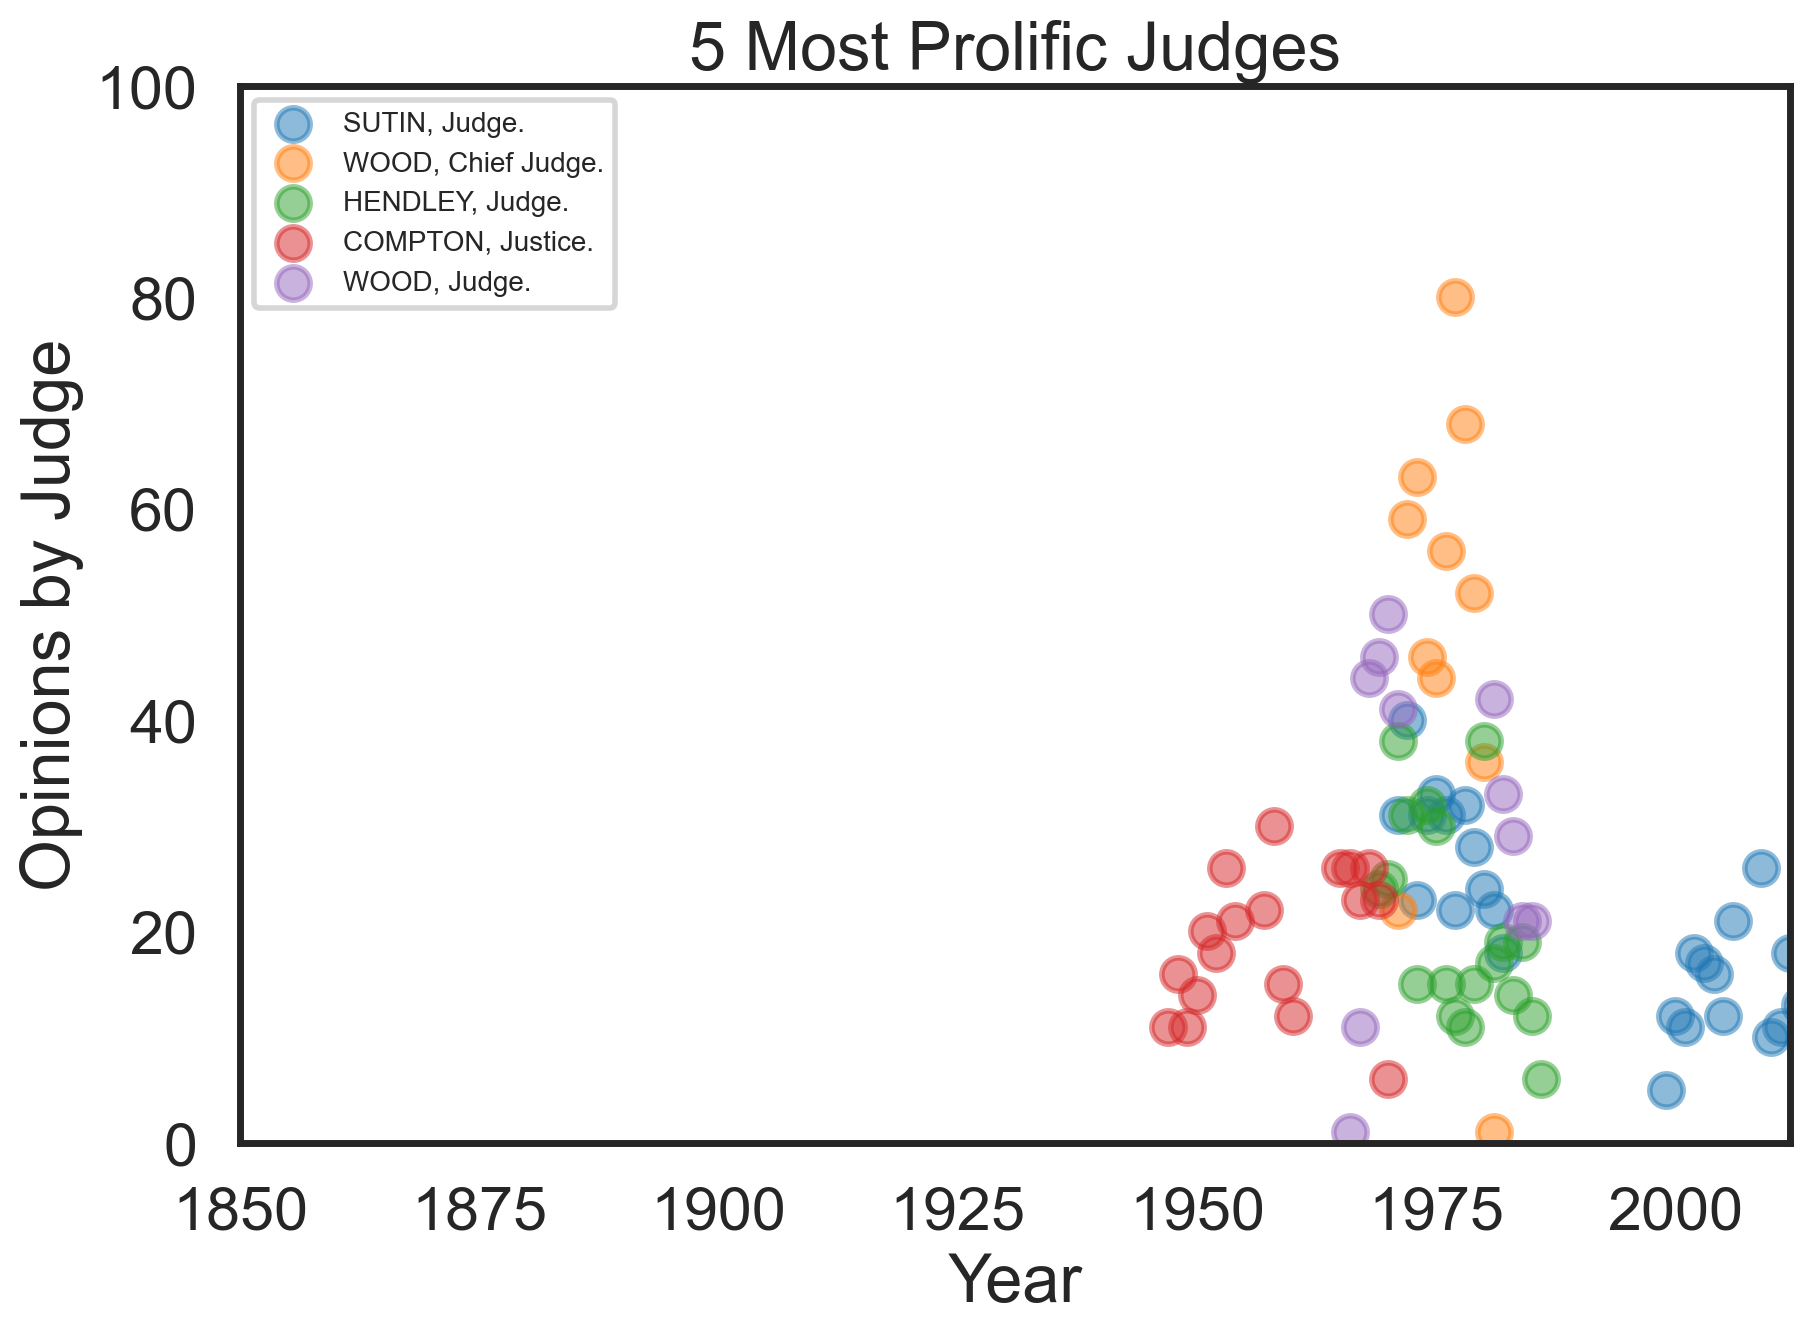

In [12]:
plt.figure(figsize=(10, 7), dpi=200)
plt.ylim(0, 100)
plt.xlim(1850, 2012)

#Get year/opinion count figures for top 5 judges
for justice in most_prolific_authors.index.tolist()[:5]:
    x,y = zip(*authors[justice].items())
    plt.scatter(x,y, alpha=0.5, label=justice)

plt.title("5 Most Prolific Judges")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(fontsize=10)
plt.savefig("prolificness2.png")
plt.show()

## Cleaning entries

In [13]:
sutin = raw_df[(raw_df["author"].str.contains('SUTIN', na=False))]

#Let's see how Sutin is listed as an author
sutin["author"].value_counts()[:15]

SUTIN, Judge.                                                  554
SUTIN, Chief Judge.                                             37
SUTIN, J.                                                       12
WOOD, Chief Judge. SUTIN, Judge                                  2
PER CURIAM. HERNANDEZ, Judge. HENDLEY, Judge. SUTIN, Judge.      1
PER CURIAM. SUTIN, Judge                                         1
PER CURIAM: SUTIN, Judge.                                        1
HERNANDEZ, Judge. SUTIN, J., specially concurring.               1
SUTIN, Judge. .                                                  1
PER CURIAM. HERNANDEZ, Judge. SUTIN, Judge. HENDLEY, Judge.      1
'SUTIN, Judge.                                                   1
"SUTIN, Judge.                                                   1
WOOD, Judge. SUTIN, Judge.                                       1
STOWERS, Justice. SUTIN, Judge.                                  1
SUTIN, Judge                                                  

As we can see the same judge appears under different aliases. Let's define a function to clean up the entries a little bit. 

In [14]:
def clean_entries(raw_df, author):
    author = raw_df[(raw_df["author"].str.contains(author, na=False))]
    print("\033[1mBEFORE:\033[0m")
    print(author["author"].value_counts())
    selection = author["author"].value_counts()[:30]
    selection_keys = list(selection.keys())
    replace_value = selection_keys[0]
    len_th = len(replace_value)+8
    aliases_justice=[]
    for i in selection_keys:
        if ("per curiam" not in i.lower()) & (len(i)<len_th):
            aliases_justice.append(i)
    author = author.replace(aliases_justice, replace_value)
    print("\n\033[1mAFTER:\033[0m")
    print(author["author"].value_counts())
    raw_df = raw_df.replace(aliases_justice, replace_value)
    return raw_df

As we want to investigate the activity of the most profilic authors, we'll apply this function to WOOD, SUTIN, COMPTON, HENDLEY, PICKARD, SADLER (our top 6 authors). 

## Sutin

In [15]:
raw_df = clean_entries(raw_df, "SUTIN")

BEFORE:
SUTIN, Judge.                                                  554
SUTIN, Chief Judge.                                             37
SUTIN, J.                                                       12
WOOD, Chief Judge. SUTIN, Judge                                  2
PER CURIAM. HERNANDEZ, Judge. HENDLEY, Judge. SUTIN, Judge.      1
PER CURIAM. SUTIN, Judge                                         1
PER CURIAM: SUTIN, Judge.                                        1
HERNANDEZ, Judge. SUTIN, J., specially concurring.               1
SUTIN, Judge. .                                                  1
PER CURIAM. HERNANDEZ, Judge. SUTIN, Judge. HENDLEY, Judge.      1
'SUTIN, Judge.                                                   1
"SUTIN, Judge.                                                   1
WOOD, Judge. SUTIN, Judge.                                       1
STOWERS, Justice. SUTIN, Judge.                                  1
SUTIN, Judge                                          

## Wood 

In [16]:
raw_df = clean_entries(raw_df, "WOOD")

BEFORE:
WOOD, Chief Judge.                                      527
WOOD, Judge.                                            339
WOOD, Judge, Court of Appeals.                           43
JOE W. WOOD, Judge, Court of Appeals.                    18
WOOD, Chief Judge                                         5
WOOD, Acting Chief Judge.                                 3
WOOD, Chief Judge. SUTIN, Judge                           2
WOOD, Judge, Court pf Appeals.                            1
'WOOD, Chief Judge.                                       1
•' JOE W. WOOD, Judge, Court of Appeals.                  1
WOOD, Judge)                                              1
■ WOOD, Judge.                                            1
WOOD, Chief Judge. HENDLEY, Judge                         1
WOOD, Chief Judge. HENDLEY, Judge. HERNANDEZ, Judge.      1
WOOD, Chief Justice.                                      1
..WOOD, Judge, Court of Appeals.                          1
WOOD, Judge, Court of Appeals:  

## Hendley 

In [17]:
raw_df = clean_entries(raw_df, "HENDLEY")

BEFORE:
HENDLEY, Judge.                                                373
HENDLEY, Chief Judge.                                           12
HENDLEY, Judge, Court of Appeals.                                3
HENDLEY, Judge!                                                  1
HENDLEY, Judge. WALTERS, Judge.                                  1
RIORDAN, Justice. HENDLEY, Judge.                                1
HENDLEY, Judge,                                                  1
PER CURIAM. HERNANDEZ, Judge. SUTIN, Judge. HENDLEY, Judge.      1
WOOD, Chief Judge. HENDLEY, Judge                                1
'HENDLEY, Judge.-                                                1
' HENDLEY, Judge.                                                1
WOOD, Chief Judge. HENDLEY, Judge. HERNANDEZ, Judge.             1
PER CURIAM. HERNANDEZ, Judge. HENDLEY, Judge. SUTIN, Judge.      1
WOOD, Judge. OMAN and HENDLEY, JJ., concur.                      1
HENDLEY, Judge. WOOD, Judge                           

## Compton

In [18]:
raw_df = clean_entries(raw_df, "COMPTON")

BEFORE:
COMPTON, Justice.                                                             346
COMPTON, Chief Justice.                                                       213
PER CURIAM. COMPTON, Justice.                                                   8
COMPTON, Chief Justice, and CARMODY, MOISE, CHAVEZ and NOBLE, Justices,         6
PER CURIAM. COMPTON, Chief Justice.                                             3
COMPTON, Acting Chief Justice, and CARMODY, MOISE and CHAVEZ, Justices,         2
PER CURIAM: COMPTON, Justice.                                                   2
■'-COMPTON, Justice.                                                            1
COMPTON, Justice..                                                              1
COMPTON, Justice. '                                                             1
MOISE, Justice. NOBLE and COMPTON, Justices (dissenting).                       1
COMPTON, Chief Justice, and,. CARMODY, CHAVEZ, NOBLE and MOISE, Justices,       1
COMPTON,

## Pickard

In [19]:
raw_df = clean_entries(raw_df, "PICKARD")

BEFORE:
PICKARD, Judge.                           306
PICKARD, J.                                29
PICKARD, Chief Judge.                      28
SUTIN, Judge. PICKARD, Judge                1
PICKARD, Judge. HARTZ, Judge                1
RANSOM, Chief Justice. PICKARD, Judge.      1
PICKARD, Judge. HARTZ, Judge.               1
OPINION PICKARD, J.                         1
PICKARD, Judge,                             1
Name: author, dtype: int64

AFTER:
PICKARD, Judge.                           365
SUTIN, Judge. PICKARD, Judge                1
PICKARD, Judge. HARTZ, Judge                1
RANSOM, Chief Justice. PICKARD, Judge.      1
PICKARD, Judge. HARTZ, Judge.               1
Name: author, dtype: int64


## Sadler

In [20]:
raw_df = clean_entries(raw_df, "SADLER")

BEFORE:
SADLER, Justice.                                                 285
SADLER, Chief Justice.                                            49
SADLER, J.                                                        21
PER CURIAM. SADLER, Justice.                                       8
PER CURIAM. SADLER, Chief Justice.                                 1
. - SADLER,. Justice.                                              1
SADLER, Justice. -                                                 1
■ SADLER, Justice.                                                 1
SADLER,' Justice.                                                  1
. SADLER, Justice.                                                 1
BRICE, Chief Justice. SADLER and McGPIEE, Justices                 1
SADLER, Justice. SHILLINGLAW, Justice (concurring specially).      1
Name: author, dtype: int64

AFTER:
SADLER, Justice.                                                 360
PER CURIAM. SADLER, Justice.                                

## Most prolific authors
Let's examine again who the most prolific authors are after cleaning up entries in the author field. 

In [26]:
most_prolific_authors = raw_df["author"].value_counts()
print(most_prolific_authors.head(15))

WOOD, Chief Judge.    884
SUTIN, Judge.         608
COMPTON, Justice.     570
HENDLEY, Judge.       390
PICKARD, Judge.       365
SADLER, Justice.      360
MOISE, Justice.       285
DONNELLY, Judge.      279
WECHSLER, Judge.      275
ALARID, Judge.        269
McGHEE, Justice.      263
WATSON, J.            260
PER CURIAM.           253
PARKER, J.            242
BUSTAMANTE, Judge.    233
Name: author, dtype: int64


In [23]:
authors = {}
for _, opinion in raw_df.iterrows():
    if opinion["author"] and "curiam" not in opinion["author"]:
        author = opinion["author"]
        year = pd.to_datetime(opinion["date"]).year
        if "curiam" in author.lower():
            author = 'Per Curiam.'
        #add to dictionary of authors with subdictionary of years for each author
        if author in authors:
            if year in authors[author]:
                authors[author][year] += 1
            else:
                authors[author][year] = 1
        else:
            authors[author] = {}
            authors[author][year] = 1

for author in authors:
    print(f"\033[1mAuthor: {author}\033[0m ")
    num_cases=0
    for year in authors[author]:
        print(f"{authors[author][year]} opinions in {year}")
        num_cases=num_cases+authors[author][year]
    print(f"In total: \033[1m{num_cases}\033[0m opinions.")
    print()

Author: MINZNER, Justice. 
15 opinions in 1997
9 opinions in 1998
10 opinions in 1996
10 opinions in 2004
7 opinions in 2005
8 opinions in 2002
3 opinions in 2001
13 opinions in 1995
9 opinions in 2003
5 opinions in 2007
7 opinions in 2006
In total: 96 opinions.

Author: WECHSLER, Judge. 
15 opinions in 1998
13 opinions in 1997
12 opinions in 1999
15 opinions in 2000
4 opinions in 1996
15 opinions in 2001
15 opinions in 2002
7 opinions in 2005
11 opinions in 1995
19 opinions in 2007
21 opinions in 2006
18 opinions in 2008
20 opinions in 2013
15 opinions in 2015
14 opinions in 2012
14 opinions in 2009
9 opinions in 2014
11 opinions in 2016
13 opinions in 2010
14 opinions in 2011
In total: 275 opinions.

Author: PICKARD, Judge. 
15 opinions in 1997
26 opinions in 1998
23 opinions in 1996
14 opinions in 1999
15 opinions in 2000
21 opinions in 2004
28 opinions in 2005
27 opinions in 2001
18 opinions in 2002
28 opinions in 1995
25 opinions in 1994
20 opinions in 1992
3 opinions in 1991
18 o

Author: TIANNA, C. J. 
1 opinions in 1917
In total: 1 opinions.

Author: PARKIER,, J. 
1 opinions in 1918
In total: 1 opinions.

Author: PARKER, ,T. 
1 opinions in 1917
In total: 1 opinions.

Author: HANNA, C. J. 
24 opinions in 1917
35 opinions in 1918
In total: 59 opinions.

Author: PABKEB, J. 
1 opinions in 1914
2 opinions in 1899
1 opinions in 1915
1 opinions in 1898
2 opinions in 1918
In total: 7 opinions.

Author: EAYNOLDS, District Judge 
2 opinions in 1914
In total: 2 opinions.

Author: ROBERTS, C. J. — 
20 opinions in 1913
3 opinions in 1914
In total: 23 opinions.

Author: NEBLETT, D. J. 
2 opinions in 1914
In total: 2 opinions.

Author: HANNA, J. — 
11 opinions in 1913
In total: 11 opinions.

Author: PARKER, J. — 
13 opinions in 1913
In total: 13 opinions.

Author: HANNA, J.- — 
1 opinions in 1913
In total: 1 opinions.

Author: BOBEETS, C. J. 
1 opinions in 1914
1 opinions in 1915
In total: 2 opinions.

Author: MECHEM, D. J. — 
1 opinions in 1914
3 opinions in 1913
In total: 

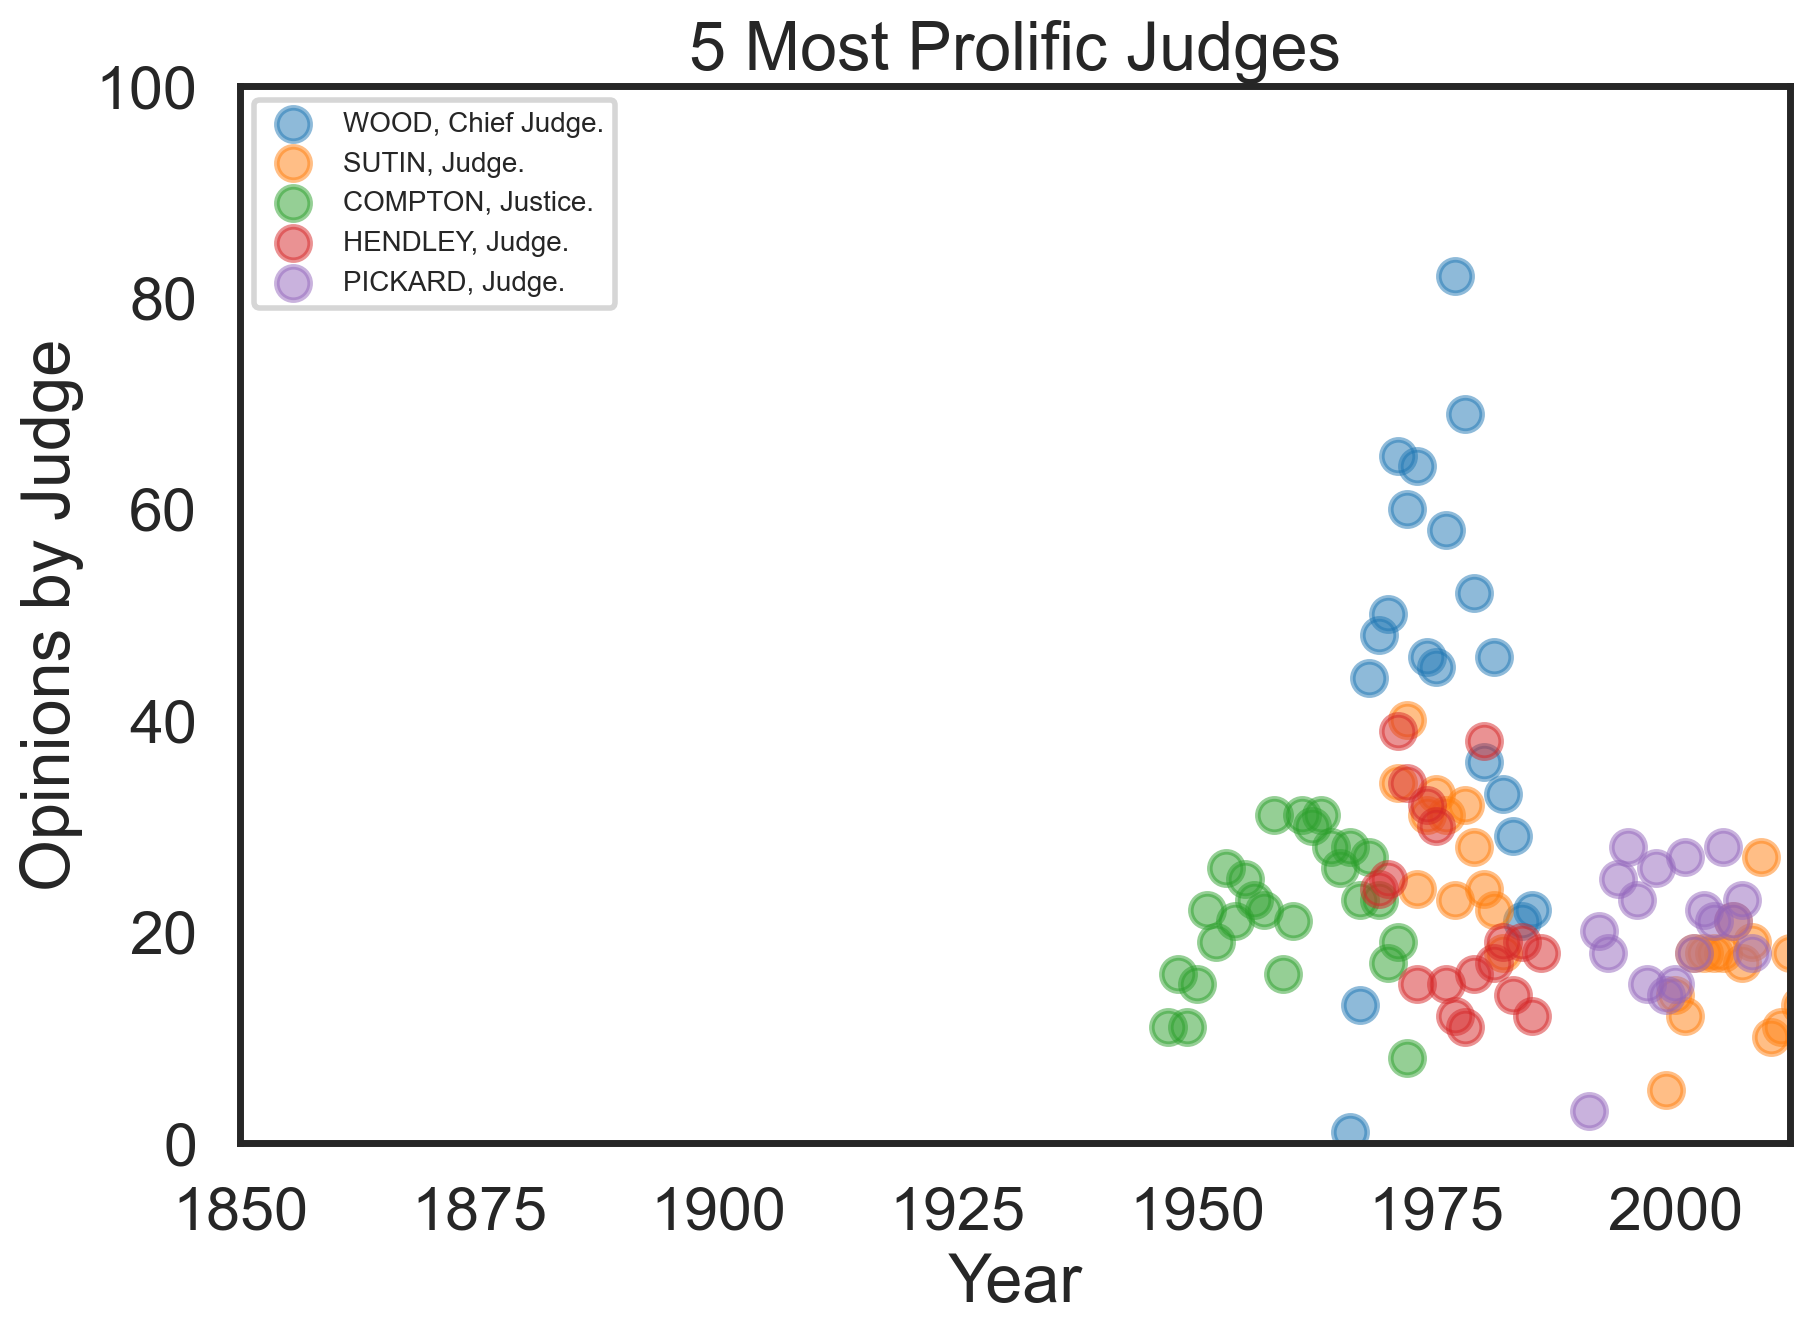

In [25]:
plt.figure(figsize=(10, 7), dpi=200)
plt.ylim(0, 100)
plt.xlim(1850, 2012)

#Get year/opinion count figures for top 5 judges
for justice in most_prolific_authors.index.tolist()[:5]:
    x,y = zip(*authors[justice].items())
    plt.scatter(x,y, alpha=0.5, label=justice)

plt.title("5 Most Prolific Judges")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(fontsize=10)
plt.savefig("prolificness2.png")
plt.show()